**This notebook is pytorch implementation for [Convolutional Neural Networks for Sentence Classification][id].compared to original paper we do some**

### **Requirement**<br>
```bash
-OSLinux-Ubuntu18.04.05  
-Data set:IMDB dataset
```
### **Data information**<br>  
-Train example nums: 17500  
-Val example nums:7500  
-test example nums:25000  
-Taget class nums:2  

[id]:https://arxiv.org/abs/1408.5882


##**Build Data and preprocess**
####In this part,we do something below:  
1.build spacy tokenizer and toknize raw text  
2.split data set to train set and val set  
3.set vocab size(contain \<unk>,<pad> special token) and collect word in train set  
4.download GLoVe pretrained Word Embedding(6B.100d) and build for our vocabulary  
5.build data loader for train,val,test data and set init Bs(64)  

In [1]:
import os
os.chdir('./gdrive/MyDrive/nl_prac')
os.getcwd()

'/content/gdrive/MyDrive/nl_prac'

In [2]:
import torch
from torch.nn import functional as F
from torch import nn,optim
from torch.optim.lr_scheduler import ExponentialLR,StepLR,MultiStepLR,LambdaLR,MultiplicativeLR,ReduceLROnPlateau
from torchtext import data,datasets

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from nlp_utils import set_rnd_seed,Model_pipeline,count_parameters,get_classMetrics,get_class_inference

import random
import numpy as np
import spacy
import os
import time

In [3]:
SEED=1234
set_rnd_seed(SEED)
spacy.require_gpu()
en_nlp=spacy.load('en_core_web_sm')
i=0
def en_tokenize(text):  
  return [t.text for t in en_nlp.tokenizer(text)]
def text_preprocess(text):
  global i
  i+=1
  if i%3000==0:
    print(f'Already convert {i} examples')
  return text
#set random seed
device=torch.device('cuda:0')

#build Field and tokenizer
Text=data.Field(tokenize=en_tokenize,lower=True,batch_first=True,preprocessing=text_preprocess)
Target=data.Field(is_target=True,batch_first=True,pad_token=None,unk_token=None)
VOCAB_size=25001#set vocabuary size

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
#load data
train_data,test_data=datasets.IMDB.splits(Text,Target)
train_data,val_data=train_data.split(split_ratio=0.7,random_state=random.seed(SEED))
print('One examples:{} from IMDB'.format(train_data.examples[0]))

#build text Embedding vector
Text.build_vocab(train_data,vectors='glove.6B.100d',max_size=VOCAB_size)
Text.vocab.set_vectors(Text.vocab.stoi,Text.vocab.vectors,dim=100)

In [5]:
#build Target vocab
Target.build_vocab(train_data)
#build data loader
Batch_size=50
train_iter,val_iter,test_iter=data.BucketIterator.splits((train_data,val_data,test_data),batch_size=Batch_size,device=device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [6]:
print('Train num:',len(train_data))
print('Val num:',len(val_data))
print('test num:',len(test_data))

Train num: 17500
Val num: 7500
test num: 25000


##**Stage2:Design Model structure**
####We build three type DL model.You can use help or .__doc__ to look model Architecture detail.

Three type model:  
1.Conv2D  
2.Cnn1D-LSTM  
3.Conv2D+Traditional ML  

And We will use init Model & data setting to evaluate three type model performance.

In [7]:
class ConvNets_2d(nn.Module):
  '''
  Class ConvNets_2d is a Neural network based on Convolution Layer.
  It's inherit from pytorch nn.Module class.So some class method is
  common.


  Architecture:
    1.Embedding_layer:This layer has three mode.One is using init Embed,
     another is using GLoVe pretrained Embed,the other is hybrid of
     GLoVe and init Embed.
    2.Convolution_layer:The three different type filter height is setting to 
     filter_size.And the filter width is fixed based on Embed dim.
     After filter,We choose ReLU for activations.For pooling strategy,
     we choose MaxPooling1D for each feature map.Finally,we concatenate
     Each feature into a single vector that genertaioned by pooling.
     
    3.Fully_connected_layer:
     This layer is output_layer.So it's shape will be 
     [n_filter*filter_size,output_dim].And it output is Logitics.


  Args:
    1.input_dim(int):This argument is used for setting Embedding input dim.
    2.embed_dim(int):This argument is used for setting Embedding dim.
    3.output_dim(int):This argument is used for whole netowrk output dim.
    4.n_filters(int):This argument is used for setting channel's num in each
     filter
    5.filter_size(list of int):This argument is set for different filter height.
     and use list to contain three filter height.
     e.g.[3,4,5].one filter'width will set three,another will set four.The other
           will set five.
    6.dropout_rate(float):This argument is used for setting final cocnated layer's
     dropout rate.
    7.pad_idx(int):This argument is used for setting index which Embed vector's is zero.
    8.pretrained_embed(torch tensor):This argument is used for loading pretrained Embedding 
     weight.Note that embed's vector nums is consistent with input_dim.
     if you don't set any torch tensor type embedding weight,it will use init random 
     Embedding layer.Default is None.
    9.is_mulc(boolean):This arguemnt is determined Whther is using Multi channel for Embed_layer.
  '''
  def __init__(self,input_dim,embed_dim,output_dim,n_filters,filter_size,
        dropout_rate,pad_idx=None,pretrained_embed=None,is_mulc=False):
    super(ConvNets_2d,self).__init__()

    #determined filter_size type and length
    assert isinstance(filter_size,tuple) and len(filter_size)==3,\
    'filter_size is not list type or len=3'
    #dteremined pretrained embed dtype and create
    if pretrained_embed is not None:
      assert isinstance(pretrained_embed,torch.tensor) and (pretrained_embed.shape[0]==input_dim),\
      "The pretrained Embed isn't a torch tensor type or nums don't equal to input_dim"

      self.is_pretrained=True
      if is_mulc:
        self.embed=nn.Embedding(input_dim,embed_dim,padding_idx=pad_idx)
        self.preEmbed=nn.Embedding.from_pretrained(pretrained_embed)
      else:
        self.preEmbed=nn.Embedding.from_pretrained(pretrained_embed)
    else:
      self.is_pretrained=False
      self.embed=nn.Embedding(input_dim,embed_dim,padding_idx=pad_idx)

    #set network main attr.
    self.input_dim=input_dim
    self.embed_dim=embed_dim
    self.output_dim=output_dim
    self.is_mulc=is_mulc
    self.inp_channels=2 if is_mulc else 1
    #create each filter height
    self.conv1=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[0],embed_dim))
    self.conv2=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[1],embed_dim))
    self.conv3=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[2],embed_dim))
    #build fc_layer
    self.fc_layer=nn.Linear(n_filters*len(filter_size),output_dim)

    #build loss criterion
    self.ReLU=nn.ReLU()
    self.dropout=nn.Dropout(dropout_rate)
    self.criterion=nn.BCEWithLogitsLoss()
  def forward(self,text,label=None,using_ml=False):
    #determined whether to use multichannel Embedding or not.
    if self.is_mulc and self.is_pretrained:
      embed_output=self.embed(text).unsqueeze(1)
      pre_embed_output=self.preEmbed(text).unsqueeze(1)
      #embed_output=[bs,2,seqlen,embed_dim]
      embed_output=torch.cat((embed_output,pre_embed_output),dim=1)
    else:
      #embed_output=[bs,1,seqlen,embed_dim]
      embed_output=self.embed(text).unsqueeze(1)
    
    #feature_map=[bs,n_filters,map_len]
    fm_1=self.ReLU(self.conv1(embed_output).squeeze(3))
    fm_2=self.ReLU(self.conv2(embed_output).squeeze(3))
    fm_3=self.ReLU(self.conv3(embed_output).squeeze(3))

    #pooled=[bs,n_filters]
    pooled_1=F.max_pool1d(fm_1,fm_1.shape[2]).squeeze(2)
    pooled_2=F.max_pool1d(fm_2,fm_2.shape[2]).squeeze(2)
    pooled_3=F.max_pool1d(fm_3,fm_3.shape[2]).squeeze(2)

    #concat pooled=[bs,n_filters*3]
    cat_pool=torch.cat((pooled_1,pooled_2,pooled_3),dim=1)
    #logitics=[Bs,1]
    logitics=self.fc_layer(cat_pool)

    #compute loss
    loss=None
    if label is not None:
      loss=self.criterion(logitics,label.float())
    if using_ml:
      return cat_pool
    else:
      return logitics,loss

In [ ]:
class Conv1d_LSTM(nn.Module):
  '''
  Class Conv1d_LSTM is a Neural network based on hybrid of Convolution Layer and LSTM_layer.
  It's inherit from pytorch nn.Module class.So some class method is common.
  

  Architecture:
    1.Embedding_layer:this layer is init random Embedding.
    2.One dimension Convolution Layer:In contrast to general Convolution filter,
    it's has single directional moving and only one dimension.and We apply it for 
    seqLen's direction to capture different time's related Info.After that,each feature
    map will be view as new embedding vector's one dimension.
    #If you want to understand how does it work,please read
    3.RNN layer:I use lstm for rnn_layer,and In Rnn output part,we will use
    Mean pooling strategy to combine information.
    4.fc and output layer:
  

  Args:
    1.input_embed(int):This argument is used for setting input dim(vocab's num).
    2.embed_dim(int):This argument is used for setting Embedding dim.
    3.output_hid(int):This argument is used for setting lstm hidden output_dim.
    4.output_dim(int):This argument is used for whole netowrk output_dim.
    5.n_filters(int):This argument is used for setting filter's num.
    6.filter_size(int):This argument is used for setting filter's length.
    7.n_layers(int):This argument is used for setting lstm layer_nums.
    8.pad_idx(int):This argument is used for setting index which Embed vector's is zero.
    9.dropout_rate(float):This argument is used for setting final cocnated layer's
     dropout rate.
    10.is_bidirectional(boolean):This argument is used for setting to use bidirectional lstm
     or not.
  '''
  def __init__(self,input_dim,embed_dim,output_hid,output_dim,n_filters,
        filter_size,n_layers,pad_idx,dropout_rate=0.1,is_bidirectional=False):
    super(Conv1d_LSTM,self).__init__()
    #model attr.
    self.input_embed=input_dim
    self.embed_dim=embed_dim
    self.pad_idx=pad_idx
    self.output_dim=output_dim
    
    #build layer
    self.embedd_layer=nn.Embedding(input_dim,embed_dim,padding_idx=pad_idx)
    self.conv1d_embed=nn.Conv1d(embed_dim,n_filters,kernel_size=filter_size)
    self.rnn_layer=nn.LSTM(n_filters,output_hid,n_layers,batch_first=True,dropout=dropout_rate,bidirectional=is_bidirectional)
    self.fc_layer=nn.Linear(output_hid,int(output_hid/2))
    self.output_layer=nn.Linear(int(output_hid/2),output_dim)


    #build activFunc.
    self.tanh=nn.Tanh()
    self.ReLU=nn.ReLU()
    self.dropout_layer=nn.Dropout(dropout_rate)

    #build metrics
    self.criterion=nn.BCEWithLogitsLoss()
  def forward(self,text,label=None):

    #tensor shape=[Bs,seqlen,embed_dim]
    embed_tensors=self.embedd_layer(text)
    #transpose and convert tensor from shape=[Bs,embed_dim,seqLen] into shape=[Bs,filter_num,pooled_seqLen]
    #In conv1d_layer,Each length(filter size) filter extract feature from embed_tensor to produce one feature map.
    #And we can view one feature map as one dim of embedding vector.So how many feature map,it's will be embedding dim.
    feature_maps=self.conv1d_embed(embed_tensors.transpose(1,2))

    #After Cnn Layer.we should transpose tensor to shape=[Bs,pooled_seqLen,filter_num]
    feature_maps=self.ReLU(feature_maps.transpose(1,2))

    #shape=[Bs,seqLen,output_hid]
    output_tensors,_=self.rnn_layer(feature_maps)

    #shape=[Bs,seqLen,output_hid/2]
    output_tensors=self.fc_layer(torch.mean(output_tensors,dim=1))

    logitics=self.output_layer(self.dropout_layer(self.ReLU(output_tensors)))

    loss=None
    if label is not None:
      loss=self.criterion(logitics,label.float())

    #return logisitcs
    return logitics,loss

In [ ]:
#build Random Forest Model
class HybridDL_model:
  '''
  Class HybridDL_model is combine Deep Learning Model and Traditional Model.
  You can use Deep Learning Model to extract data feature, and then pass this 
  feature to ML_model to predict. 
  In other word,your DL model is pretrained Model,you only fine-tuning your ml model
  params to predict.


  Architecture:
   1.DL_model:your trained DL model
   2.ML_model:your ml_model.
  

  Args:
   1.ML_model(sklearn Model class):sklearn Model class.
   2.DL_model(torch.Module object):torch.nn.module object
   3.ml_kwargs(dict):This arg is set for your ml_model.Note that because using incremental learning.So your args should set incremental
   4.device(torch.device):torch device object.
  '''
  def __init__(self,ML_model,DL_model,ml_kwargs,device):
    #build Model
    self.ml_model=ML_model(**ml_kwargs)
    self.DL_model=DL_model
    assert isinstance(self.DL_model,nn.Module),'This object is not torch.nn'
    self.ml_kwargs=ml_kwargs
    self.device=device
  def online_train(self,input_iters):
    #extract feature using dl_model

    self.DL_model.eval()
    with torch.no_grad():
      for bs in input_iters:
        if next(self.DL_model.parameters()).is_cuda:
          input_texts=bs.text.to(self.device)
          labels=bs.label.to(self.device).squeeze(dim=1)
        else:
          input_texts=bs.text
          labels=bs.label.squeeze(dim=1)
        #x_logitics shape=[bs,feature_dim]
        x_logitics=self.DL_model(input_texts,using_ml=True)
        #convert to numpy array
        x_logitics=x_logitics.cpu().clone().numpy()
        #online training ML_model
        self.ml_model.fit(x_logitics,labels.cpu().clone().numpy())
      
      #evaluate hybrid Model
      acc=self.evaluate_model(train_iter)
      print(f'Hybrid Model Training Accuracy:{acc}')
  def evaluate_model(self,val_iter):
    total_accuracy=0
    total_Fscore=0
    self.DL_model.eval()
    with torch.no_grad():
      for bs in val_iter:
        if next(self.DL_model.parameters()).is_cuda:
          input_texts=bs.text.to(self.device)
          labels=bs.label.to(self.device).squeeze(dim=1)
        else:
          input_texts=bs.text
          labels=bs.label.squeeze(dim=1)
        #x_logitics shape=[bs,feature_dim]
        x_logitics=self.DL_model(input_texts,using_ml=True)
        #convert to numpy array
        x_logitics=x_logitics.cpu().clone().numpy()
        labels=labels.cpu().clone().numpy()
        #online training ML_model
        accuracy=self.ml_model.score(x_logitics,labels)
        predicts=self.ml_model.predict(x_logitics)
        total_accuracy+=accuracy
        total_Fscore+=metrics.f1_score(labels,predicts)
    
    return total_accuracy/len(val_iter),total_Fscore/len(val_iter)
  def predict(self,input_tensors):
    x_logitics=self.DL_model(input_tensors,using_ml=True)
    x_logitics=x_logitics.cpu().clone().detach().numpy()

    #model_predict
    predicts=self.ml_model.predict(x_logitics)
    return predicts

##Compared different Model performance
We set params to compare model performance.

####Common
```bash
Input_dim=25001
Embed_dim=100
output_dim=1
pad_idx='<pad>' in vicab index
n_epochs=13
```

####For conv2d
```bash
filters_num=100
dropout_rate=0.5
3 type kernel size filter=(3,4,5)
```
####For cnn-lstm
```bash
filters_num=256
hidden(lstm)_output=128
hidden_layers=2
dropout_rate=0.1
1 type kernel size filter=3
```
####For hybrid(cnn,ml)
```bash
1.DL_model=conv2d
2.ml_model=RandomForest
3.Rf_params={'n_estimators':145,'max_depth':5,'n_jobs':-1,'warm_start':True}
```


###**Model performance compared**
|       | Train loss |val loss| test loss| 
| ----- | ------     | ---    | ---------|
| Conv2d | 84e-4 | 0.4249 |0.417|
| Cnn-Lstm|0.013 | 1.993 | 2.235|
| Hybrid| - | - |- | 

|       | Train acc|val acc| test acc|train F-score| val F-score| test F-score|
| ----- | ------ | --- | ---- | ------------- | ----------- |------|
| Conv2d| 1.0   | 0.873 | 0.872| 1.0      | 0.876    |0.803|
|Cnn-Lstm|0.998 |0.845  | 0.827| 0.998    | 0.851   |0.762|
| Hybrid| 0.948 |0.797  | 0.799| 0.945      | 0.779  |0.704|

In [9]:
model_configs={'input_dim':len(Text.vocab),'embed_dim':100,'output_dim':1,
        'n_filters':100,'filter_size':(3,4,5),'dropout_rate':0.5,'pad_idx':Text.vocab.stoi['<pad>']}
N_epochs=13
save_path='./model/cnn2d/'
# #build Conv2d network
conv2d_model=ConvNets_2d(**model_configs)
conv2d_model.to(device)
cnn_optim=optim.Adam(conv2d_model.parameters())
print('CovNets model scheme:{}'.format(conv2d_model))
print(f'Model trainable parameters num:{count_parameters(conv2d_model)}')

CovNets model scheme:ConvNets_2d(
  (embed): Embedding(25003, 100, padding_idx=1)
  (conv1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  (conv3): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  (fc_layer): Linear(in_features=300, out_features=1, bias=True)
  (ReLU): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (criterion): BCEWithLogitsLoss()
)
Model trainable parameters num:2620901


In [ ]:
#build train pipeline
train_cnn2d=Model_pipeline(conv2d_model,train_iter,cnn_optim,None,val_iter,model_configs)
train_cnn2d.amp_training(N_epochs,save_path,'text','label',eval_func=get_classMetrics)

In [ ]:
#build Cnn-lstm Model
cnnLstm_configs={'input_dim':len(Text.vocab),'embed_dim':100,'output_hid':256,'output_dim':1,
        'n_filters':100,'filter_size':3,'n_layers':2,'dropout_rate':0.2,'pad_idx':Text.vocab.stoi['<pad>']}
save_cnnLstm_path='./model/cnn1d_lstm/'
cnnLstm_model=Conv1d_LSTM(**cnnLstm_configs)
cnnLstm_model.to(device)
Lstm_optim=optim.Adam(cnnLstm_model.parameters())
print('cnn-lstm model scheme:{}'.format(cnnLstm_model))
print(f'Model trainable parameters num:{count_parameters(cnnLstm_model)}')

cnn-lstm model scheme:Conv1d_LSTM(
  (embedd_layer): Embedding(25003, 100, padding_idx=1)
  (conv1d_embed): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
  (rnn_layer): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc_layer): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (tanh): Tanh()
  (ReLU): ReLU()
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (criterion): BCEWithLogitsLoss()
)
Model trainable parameters num:3456353


In [ ]:
#build train pipeline
train_cnnLstm=Model_pipeline(cnnLstm_model,train_iter,Lstm_optim,None,val_iter,cnnLstm_configs)
train_cnnLstm.amp_training(N_epochs,save_cnnLstm_path,'text','label',eval_func=get_classMetrics)

# **Inference stage**
In inference stage,we can use trained model to predict input sentences sentiment.<br>
**Note**:if we input sentence length less than filter window size.model will be not work.So we set min_length argument.if sent_length<min_len,we pad sent that length equal to min_length argument.

In [ ]:
test_example=test_data.examples[0]
test_sent=test_example.text
sentiment_score=get_class_inference(conv2d_model,test_sent,Text,True,50)
print('-'*10+'Model predict'+'-'*10)
print(f"Test_text:{' '.join(test_sent)}\nsentiment:{Target.vocab.itos[sentiment_score[0]]}")
print(f'True label:{test_example.label[0]}')

----------Model predict----------
Test_text:boogie nights is one of the best films to come out of the 90 's and i 'd go so far as to say it should be in the imdb top 250 . i can actually understand why many would dislike it , due to the subject matter . i personally feel however as many do , judging from the aclaim this film 's received by viewers and critics that it 's topnotch film making.<br /><br />the direction and acting in this film surpass good and reach the level of brilliance . there is not one scene in this movie that is n't amazing . the individual characters reach out and touch you . given that this is a movie about the porn industry , one would n't imagine the sex scenes could be handled with such sensitivity but they are . the direction is among the best i 've ever seen - and i 've seen a lot of films.<br /><br />the film is n't about one particular personal individual 's story , it 's about many . it 's a character study about people who have many layers to them and who

#**Extra expirement**
We use other hyperparameter Strategy for experiment Model performance.<br>
&nbsp;

####It's contain:<br>
 1.MiniBatch Size(128,256,512,1024)<br>
 2.Learning Rate and Learning Rate schedule<br>
 3.different type optimizer(SGD,RMSprop,Adgrad,Adam)<br>
 4.Warm-up and linear scaling rule

In [15]:
#display model loss time trend
import matplotlib.pyplot as plt
from math import ceil
# def autoLabel(line_2ds,ax):
#   xy_data=line_2ds[0].get_xydata()
#   for idx in range(xy_data.shape[0]):
#     ax.annotate(
#         '{:.3f}'.format(xy_data[idx,1]),xy=(xy_data[idx,0],xy_data[idx,1]),
#         xytext=(0,4),textcoords='offset points',ha='center',va='bottom')
  
def plot_Loss(times,times_loss,markers,colors,labels,titles):
  """
  This function is used to display model loss on different type condition in datas.

  Parameters:
   times(list of int):This arg is set for plot x_tick and labels.
   times_loss(lists of list of different type loss):This first dim of arg represents each data.The second dim will 
                                                    represent each condition over data,and third's will represent loss
                                                    at each times in condition.
   markers(list of marker):This arg set marker for each data.
   colors(list fo color):This arg set condition's color for each data.
   labels(list of str):This arg set condition's name  for each data.
   titles(list of str):This arg set title for each data.
  """


  rows=ceil(len(time_loss[0])/1)
  fig=plt.figure(figsize=(10,8))
  

  #plot lines
  for idx in range(0,rows):
    ax=fig.add_subplot(rows,1,idx+1)
    for tl,m,c,l in zip(times_loss,markers,colors,labels):
      line2ds=ax.plot(times,tl[idx],color=c,label=l,marker=m,ms=1.3)

      ax.set_xticks(times)
      ax.set_xticklabels(times)
      ax.set_xlabel('Epochs')
      ax.set_ylabel('Loss')
      ax.set_title(titles[idx])
      ax.legend()
  fig.tight_layout()
  plt.show()

###**First Experiment is test that whether different Learning Rate has  different influence on model performance.**
  After runing Model,we discover  
  >When Training BS increase,val loss will decrease and train loss will higher than lower Bs.

This result is the same as past research discovered.
The reason is when increase Bs will improve model generalization,but it update model weight times will decrease.So if it has the same Epoch nums condition,Model will convergence slower than small Batch size.



In [ ]:
#training model with different Batch_size
optim_loss={}
Bs_params={'Bs_50':50,'Bs_128':128,'Bs_256':256,'Bs_512':512,'Bs_1024':1024}
for names in Bs_params.keys():
  #build diff bs iterator
  train_iter,val_iter,test_iter=data.BucketIterator.splits((train_data,val_data,test_data),batch_size=Bs_params[names],device=device)

  #build Model
  conv2d_model=ConvNets_2d(**model_configs)
  conv2d_model.to(device)
  cnn_optim=optim.Adam(conv2d_model.parameters())
  train_cnn2d=Model_pipeline(conv2d_model,train_iter,cnn_optim,None,val_iter,model_configs)
  #train & get loss(train,val)
  train_loss,val_loss=train_cnn2d.amp_training(N_epochs,save_path,'text','label',eval_func=get_classMetrics,per_ep_eval=1)
  optim_loss[names]=(train_loss,val_loss)

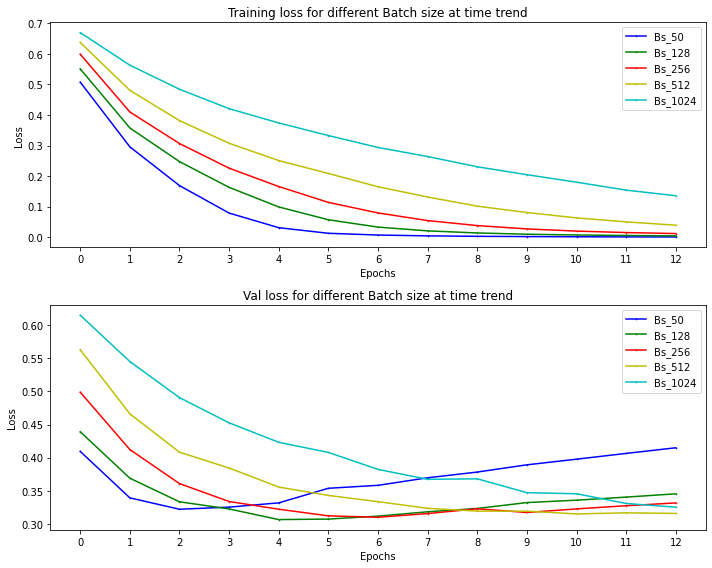

In [ ]:
x_times=range(0,N_epochs)
titles=['Training loss for different Batch size at time trend','Val loss for different Batch size at time trend']

labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y','c']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

###**Second Experiment is test that whether different apative LR method has  different influence on model performance.**
 Before training,we set some condition:  
1.Data Btach size=256  
2.Model lr=1e-2  
  
  
####*Result has show Adagrad is the best suitable for this Model and Dataset.*

In [ ]:
train_iter,val_iter,test_iter=data.BucketIterator.splits((train_data,val_data,test_data),batch_size=128,device=device)
#training model with different optimizer,and we set 1e-2 for each optimizer learning rate.
optim_loss={}
optim_params={'SGD':optim.SGD,'RMSprop':optim.RMSprop,'Adagrad':optim.Adagrad,'Adam':optim.Adam}
for names in optim_params.keys():
  #build Model
  conv2d_model=ConvNets_2d(**model_configs)
  conv2d_model.to(device)
  optimizer=optim_params[names](conv2d_model.parameters(),lr=1e-2)
  train_cnn2d=Model_pipeline(conv2d_model,train_iter,optimizer,None,val_iter,model_configs)
  #train & get loss(train,val)
  train_loss,val_loss=train_cnn2d.amp_training(N_epochs,save_path,'text','label',eval_func=get_classMetrics,per_ep_eval=1)
  optim_loss[names]=(train_loss,val_loss)

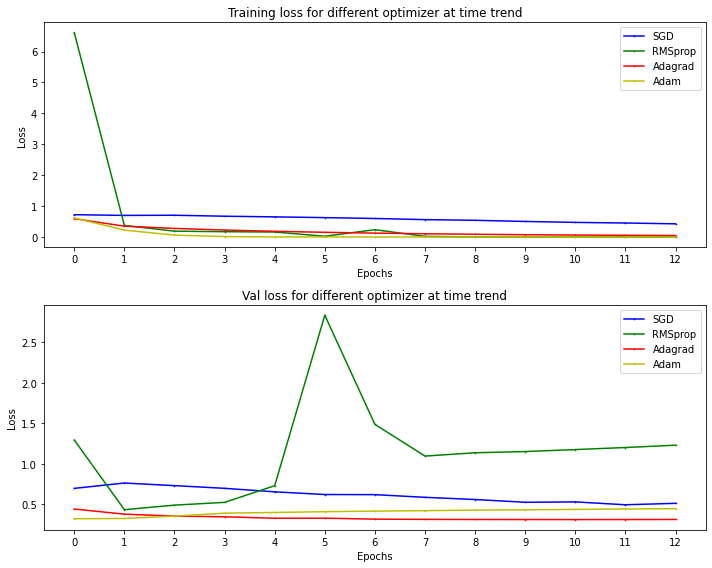

In [ ]:
#plot training and val
labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y']
titles=['Training loss for different optimizer at time trend','Val loss for different optimizer at time trend']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

###**Third Experiment is test that whether different LR  has  different influence on model performance.**
 Before training,we set some condition:  
1.Data Btach size=256  
2.Model lr=1e-2  
3.optimizer=Adagrad
  
  
####*Result has show lr(1e-2)  is the best suitable for this Model and Dataset.*

In [ ]:
#training model with different learning rate.
Batch_size=256
optim_loss={}
lr_params={'lr_1e-1':1e-1,'lr_1e-2':1e-2,'lr_1e-3':1e-3,'lr_1e-4':1e-4,'lr_1e-5':1e-5}

for names in lr_params.keys():
  #build Model
  conv2d_model=ConvNets_2d(**model_configs)
  conv2d_model.to(device)
  optimizer=optim.Adam(conv2d_model.parameters(),lr=lr_params[names])

  #collect Model info
  train_cnn2d=Model_pipeline(conv2d_model,train_iter,optimizer,None,val_iter,model_configs)
  #train & get loss(train,val)
  train_loss,val_loss=train_cnn2d.amp_training(N_epochs,save_path,'text','label',eval_func=get_classMetrics,per_ep_eval=1)
  optim_loss[names]=(train_loss,val_loss)



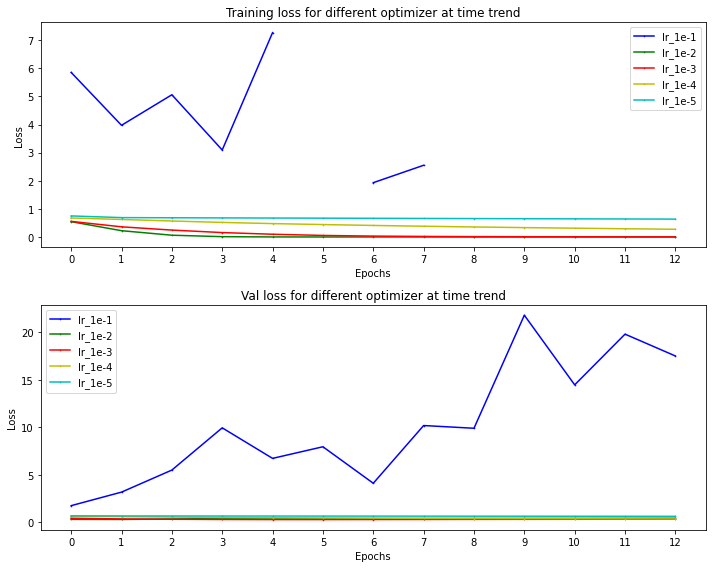

In [ ]:
#plot training and val
labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y','c']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

###**Fourth Experiment is test that whether different LR_scheduler  has  different influence on model performance.**
 Before training,we set some condition:  
1.Data Btach size=256  
2.init lr=0.75  
3.optimizer=momentum SGD  
  
####And Result discover something interesting.Compared to original using SGD,*when we use SGD with lr_scheduler strategy to training,it will be worked.*

In [ ]:
#using different type learning Rate scheduler to train Model
#define linear decay func
linear_lambda=lambda epoch:(N_epochs-epoch)/N_epochs
Batch_size=256
optim_loss={}
lr_params={'exp_decay':(ExponentialLR,{'gamma':0.85}),'step_deacy(3)':(StepLR,{'step_size':3,'gamma':0.5}),'Linear_Decay':(LambdaLR,{'lr_lambda':linear_lambda}),
      'Muti_step':(MultiStepLR,{'milestones':[3,5]+list(range(7,9))})}

for names in lr_params.keys():
  #build Model
  conv2d_model=ConvNets_2d(**model_configs)
  conv2d_model.to(device)
  optimizer=optim.SGD(conv2d_model.parameters(),lr=75e-3,momentum=0.9,dampening=5e-1)

  scheduler=lr_params[names][0](optimizer,**lr_params[names][1])
  #collect Model info
  train_cnn2d=Model_pipeline(conv2d_model,train_iter,optimizer,scheduler,val_iter,model_configs)
  #train & get loss(train,val)
  train_loss,val_loss=train_cnn2d.amp_training(N_epochs,save_path,'text','label',eval_func=get_classMetrics,per_ep_eval=1)
  optim_loss[names]=(train_loss,val_loss)

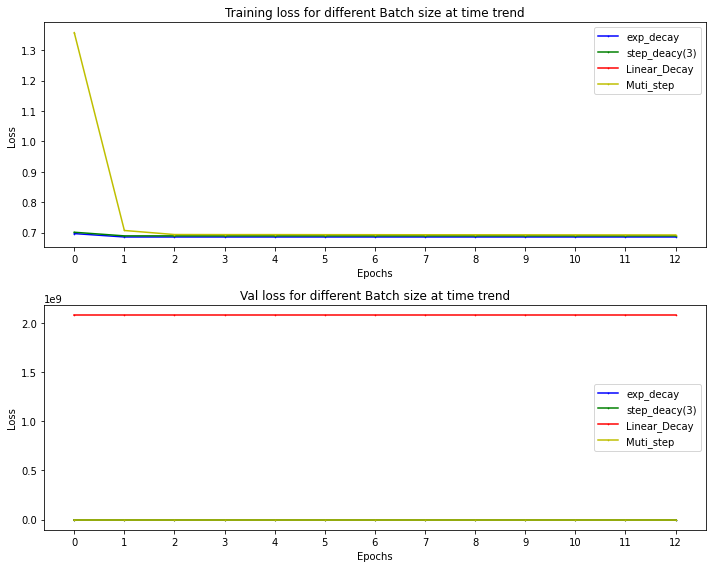

In [17]:
#plot training and val
x_times=range(0,N_epochs)
titles=['Training loss for different Batch size at time trend','Val loss for different Batch size at time trend']

labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)